In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import numpy as np

from feature_extraction import get_features, get_targets, make_train_test_split

plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

np.random.seed(42)

def read_kaggle_json(filepath):
    filepath = os.path.expanduser(filepath)
    username = None
    token = None
    with open(filepath, "r") as file:
        config = json.load(file)
        username = config.get("username")
        token = config.get("key")
    return username, token


kaggle_json_filepath = "/workspaces/fall-2024-class-08/kaggle/kaggle.json"
kaggle_username, kaggle_api_token = read_kaggle_json(kaggle_json_filepath)

if kaggle_username and kaggle_api_token:
    os.environ["KAGGLE_USERNAME"] = kaggle_username
    os.environ["KAGGLE_KEY"] = kaggle_api_token

import kaggle

dataset_name = "andrewmvd/sp-500-stocks"
download_location = "/workspaces/fall-2024-class-08/downloads"

kaggle.api.authenticate()
kaggle.api.dataset_download_files(
    dataset_name, path=download_location, unzip=True
)

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks


In [2]:
stocks_file_path = "/workspaces/fall-2024-class-08/downloads/sp500_stocks.csv"
index_file_path = "/workspaces/fall-2024-class-08/downloads/sp500_index.csv"
companies_file_path = (
    "/workspaces/fall-2024-class-08/downloads/sp500_companies.csv"
)

stocks_df = pd.read_csv(stocks_file_path)
index_df = pd.read_csv(index_file_path)
companies_df = pd.read_csv(companies_file_path)
dates = stocks_df["Date"].unique()
symbols = companies_df["Symbol"].unique()
print(symbols)

['AAPL' 'NVDA' 'MSFT' 'GOOGL' 'GOOG' 'AMZN' 'META' 'BRK-B' 'AVGO' 'TSLA'
 'LLY' 'WMT' 'JPM' 'V' 'XOM' 'UNH' 'ORCL' 'MA' 'COST' 'PG' 'HD' 'JNJ'
 'ABBV' 'BAC' 'NFLX' 'CRM' 'KO' 'CVX' 'AMD' 'TMUS' 'MRK' 'PEP' 'ACN' 'LIN'
 'WFC' 'CSCO' 'ADBE' 'MCD' 'TMO' 'BX' 'PM' 'ABT' 'NOW' 'QCOM' 'IBM' 'TXN'
 'MS' 'AXP' 'GE' 'CAT' 'ISRG' 'DHR' 'INTU' 'DIS' 'VZ' 'NEE' 'AMGN' 'UBER'
 'GS' 'RTX' 'CMCSA' 'PFE' 'T' 'AMAT' 'LOW' 'SPGI' 'BKNG' 'BLK' 'PGR' 'UNP'
 'ETN' 'SYK' 'HON' 'SCHW' 'LMT' 'KKR' 'TJX' 'ANET' 'BSX' 'VRTX' 'C' 'MU'
 'COP' 'PANW' 'ADP' 'CB' 'ADI' 'NKE' 'MDT' 'UPS' 'FI' 'DE' 'SBUX' 'GILD'
 'PLD' 'MMC' 'BMY' 'AMT' 'REGN' 'LRCX' 'PLTR' 'SO' 'INTC' 'ELV' 'ICE' 'BA'
 'KLAC' 'HCA' 'MDLZ' 'SHW' 'DUK' 'TT' 'CI' 'WM' 'EQIX' 'ABNB' 'MO' 'WELL'
 'DELL' 'CTAS' 'MCO' 'GD' 'APH' 'CMG' 'CEG' 'ZTS' 'GEV' 'CME' 'PYPL'
 'SNPS' 'PH' 'AON' 'CL' 'CDNS' 'MSI' 'ITW' 'USB' 'PNC' 'TDG' 'NOC' 'MAR'
 'CRWD' 'ECL' 'CVS' 'APD' 'MMM' 'EOG' 'ORLY' 'BDX' 'TGT' 'FDX' 'CARR'
 'FCX' 'MCK' 'NXPI' 'SPG' 'CSX' 'RSG' 'WMB' 'COF' 'A

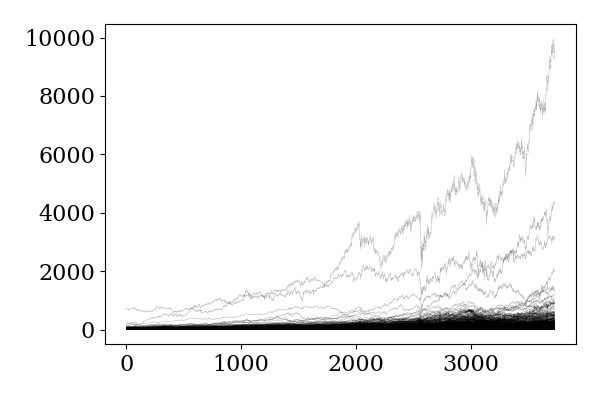

In [3]:
# Specify the target symbol to predict, number of days of history to use in the
# autoregressive model, and number of days forward to predict.
# Increasing the history (to 20, 50, etc.) will increase the smoothness.
n_days_history = 1
n_days_forward = 1

# Get the dataset
x_features = get_features(
    dates, stocks_df, n_days_history, n_days_forward, predictor_symbols=symbols
)

plt.figure(figsize=(6, 4))
plt.plot(x_features, color="k", linewidth=0.1, alpha=0.5)
plt.tight_layout()

In [4]:
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
from scipy.stats import kurtosis

In [7]:
# Remove NaNs
x_features[np.isnan(x_features)] = 0

# Standardize
scaler = StandardScaler()
x_features_scaled = scaler.fit_transform(x_features)

n_components_candidates = np.arange(2, 30)
peak_to_avg_gaussianity_measures = []


# Search for the right number of components by checking when one component
# becomes much more gaussian than the others
def compute_gaussianity_measure(x_features_transformed):
    gaussianity_measures = np.abs(1 / kurtosis(x_features_transformed, axis=0))
    return gaussianity_measures


def compute_peak_to_average_gaussianity_measure(
    compute_gaussianity_measure, x_features_transformed
):
    gaussianity_measures = compute_gaussianity_measure(x_features_transformed)
    peak_to_avg_gaussianity_measure = np.max(
        gaussianity_measures
    ) / np.average(gaussianity_measures)

    return peak_to_avg_gaussianity_measure


for n_components in n_components_candidates:
    ica = FastICA(
        n_components=n_components,
        whiten="arbitrary-variance",
        tol=1e-7,
        max_iter=500,
        random_state=42,
    )
    x_features_transformed = ica.fit_transform(x_features_scaled)

    peak_to_avg_gaussianity_measure = (
        compute_peak_to_average_gaussianity_measure(
            compute_gaussianity_measure, x_features_transformed
        )
    )
    peak_to_avg_gaussianity_measures.append(peak_to_avg_gaussianity_measure)
    print(
        "Checked n_components = {}, peak to avg. Gaussianity ratio = {}".format(
            n_components, peak_to_avg_gaussianity_measure
        )
    )

Checked n_components = 2, peak to avg. Gaussianity ratio = 1.1345940336846534
Checked n_components = 3, peak to avg. Gaussianity ratio = 1.3843296000308742
Checked n_components = 4, peak to avg. Gaussianity ratio = 1.7399133913783653
Checked n_components = 5, peak to avg. Gaussianity ratio = 2.3828036937713715
Checked n_components = 6, peak to avg. Gaussianity ratio = 2.0559942019169273
Checked n_components = 7, peak to avg. Gaussianity ratio = 2.503696969903556


/workspaces/fall-2024-class-08/.venv/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Checked n_components = 8, peak to avg. Gaussianity ratio = 2.781601851949794
Checked n_components = 9, peak to avg. Gaussianity ratio = 2.40100193686999
Checked n_components = 10, peak to avg. Gaussianity ratio = 2.8767611499607924
Checked n_components = 11, peak to avg. Gaussianity ratio = 2.8085643219085754
Checked n_components = 12, peak to avg. Gaussianity ratio = 3.296456313816616
Checked n_components = 13, peak to avg. Gaussianity ratio = 3.850370283877447
Checked n_components = 14, peak to avg. Gaussianity ratio = 4.240145715708044
Checked n_components = 15, peak to avg. Gaussianity ratio = 3.0732188713839474
Checked n_components = 16, peak to avg. Gaussianity ratio = 2.6457989272336953
Checked n_components = 17, peak to avg. Gaussianity ratio = 2.7712973308192708
Checked n_components = 18, peak to avg. Gaussianity ratio = 2.8000611647349083
Checked n_components = 19, peak to avg. Gaussianity ratio = 2.9278936381563185
Checked n_components = 20, peak to avg. Gaussianity ratio = 

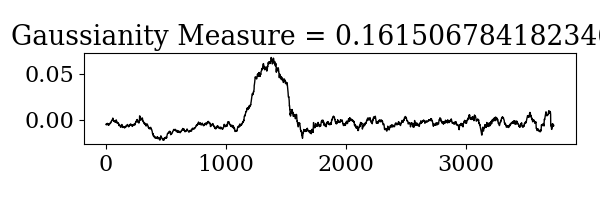

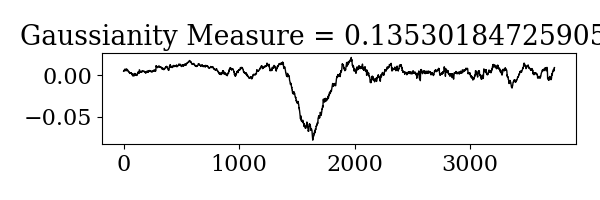

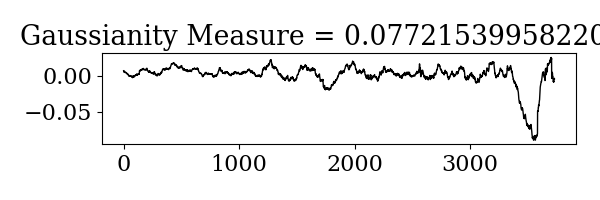

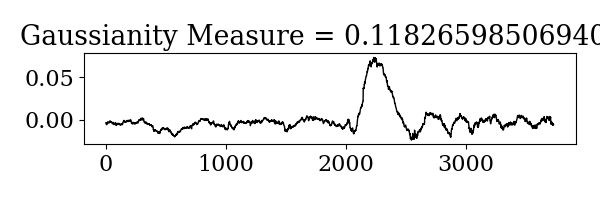

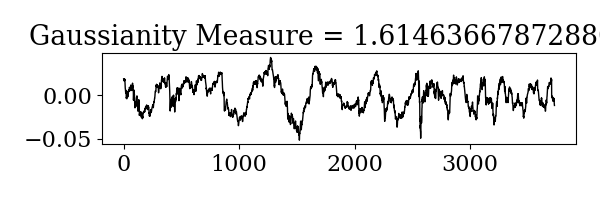

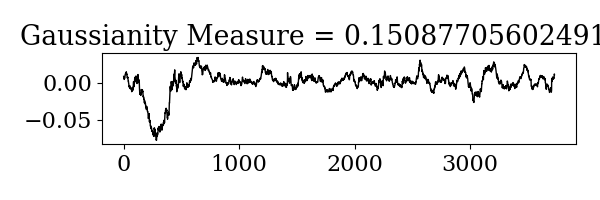

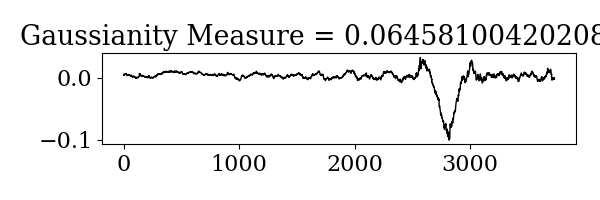

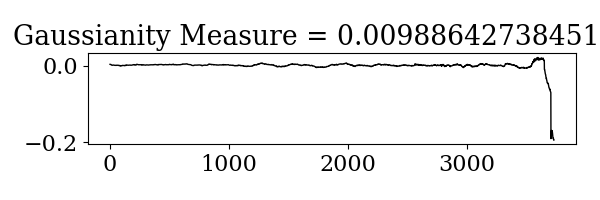

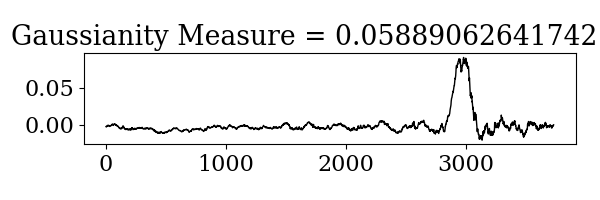

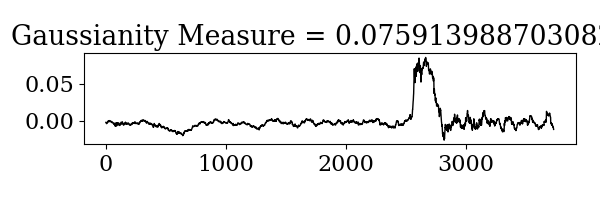

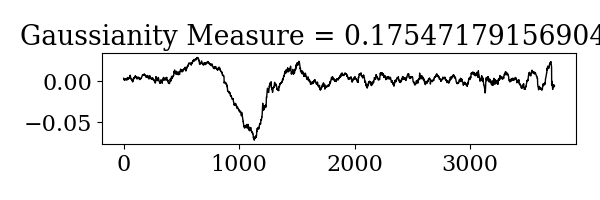

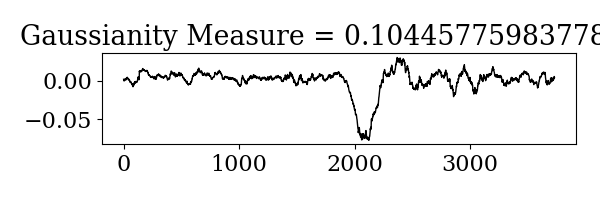

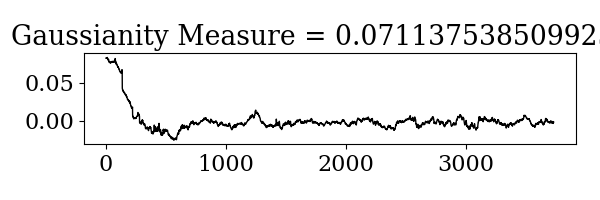

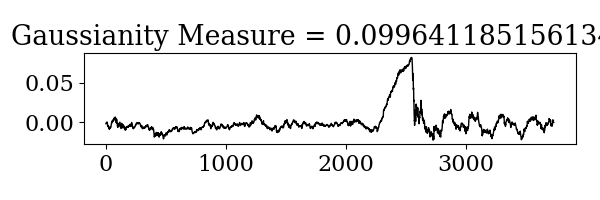

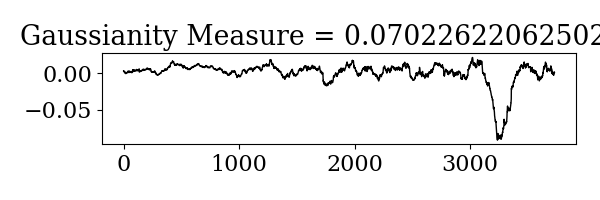

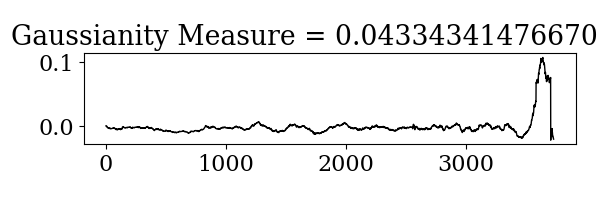

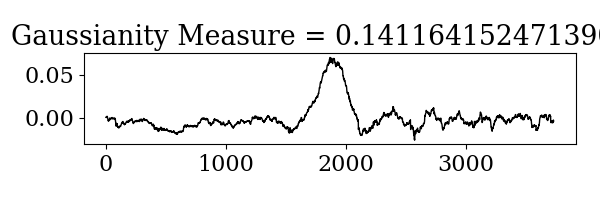

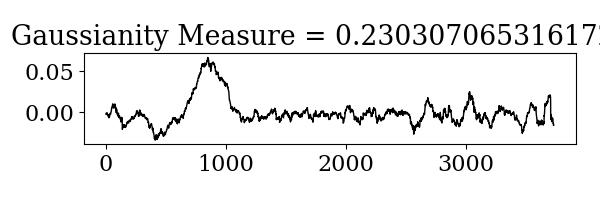

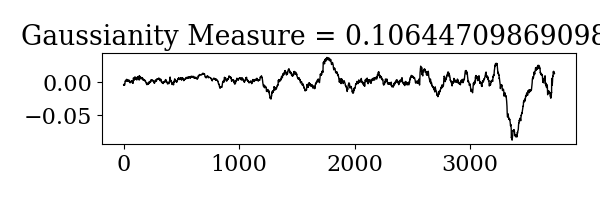

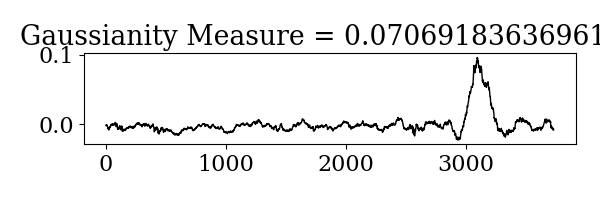

In [9]:
n_components = 20
ica = FastICA(
    n_components=n_components,
    whiten="arbitrary-variance",
    tol=1e-7,
    max_iter=500,
    random_state=42,
)

x_features_transformed = ica.fit_transform(x_features_scaled)

for idx in range(x_features_transformed.shape[1]):
    signal_component = x_features_transformed[:, idx]
    gaussianity_measure = compute_gaussianity_measure(signal_component)
    plt.figure(figsize=(6, 2))
    plt.plot(signal_component, color="k", linewidth=1)
    plt.title("Gaussianity Measure = {}".format(gaussianity_measure))
    plt.tight_layout()

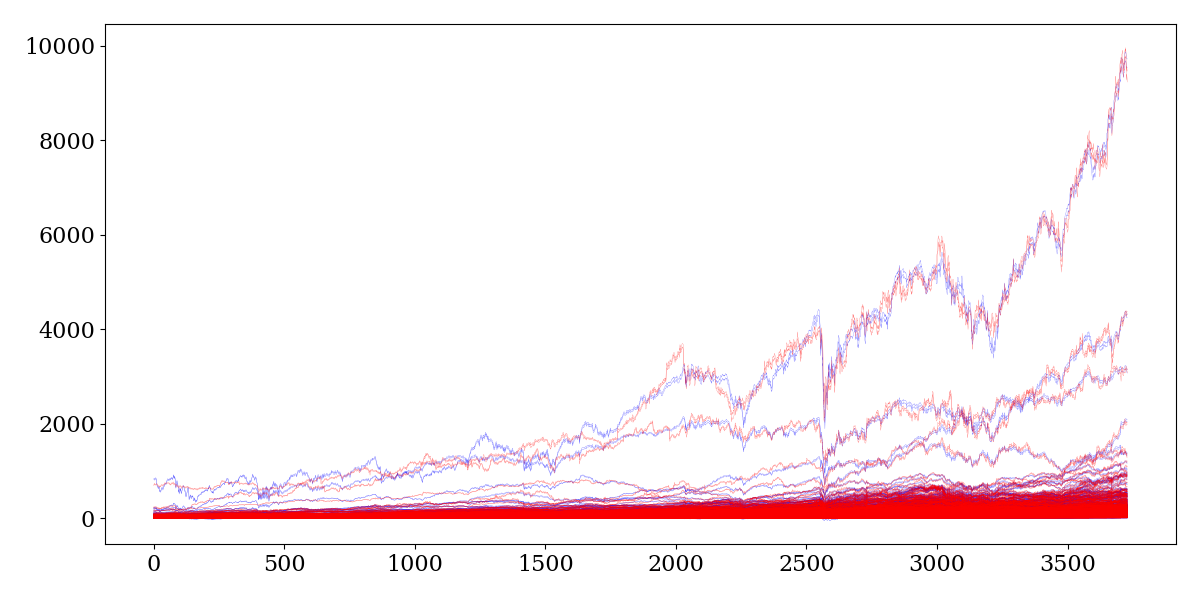

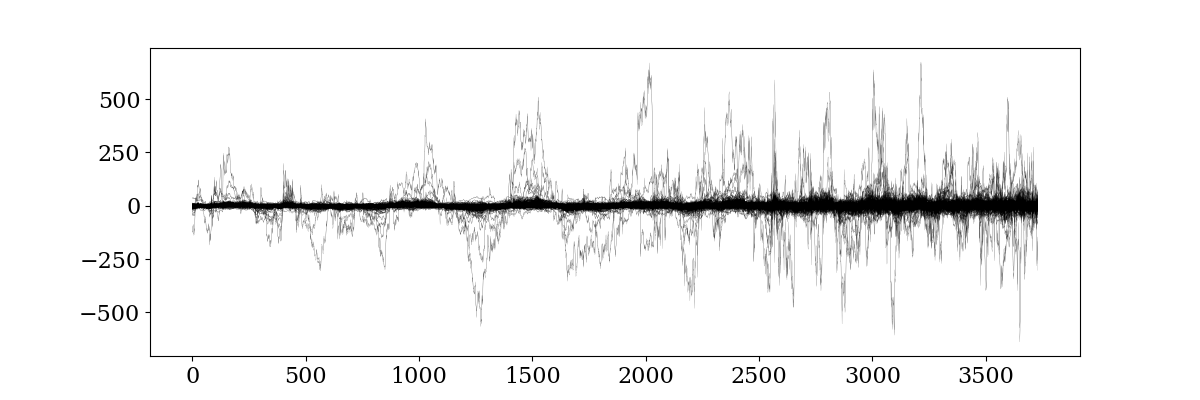

In [15]:
gaussianity_measures = compute_gaussianity_measure(x_features_transformed)
noise_component_index = np.argmax(gaussianity_measures)

x_features_transformed[:, noise_component_index] = 0

x_features_reconstructed = ica.inverse_transform(x_features_transformed)
x_smooth_original_scale = scaler.inverse_transform(x_features_reconstructed)

delta = x_features - x_smooth_original_scale

plt.figure(figsize=(12, 6))
plt.plot(x_smooth_original_scale, color="b", linewidth=0.15, alpha=0.75)
plt.plot(x_features, color="r", linewidth=0.15, alpha=0.75)
plt.tight_layout()

plt.figure(figsize=(12, 4))
_ = plt.plot(delta, color="k", linewidth=0.1, alpha=0.75)